### Instructor Demo: Stock Price Simulation

This program executes a single simulation of stock price trajectory over the next `252` trading days (or year of trading) for `AAPL` stock, based on a normal probability distribution of historical average daily returns derived from the sample mean and standard deviation.

In [6]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
import alpaca_trade_api as tradeapi

%matplotlib inline

In [7]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

print(alpaca_api_key)
print(alpaca_secret_key)

# Initialize Alpaca object
api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version="v2")

PKOU6HF64Z27IXP0CES3
iNYOHvdaWL3SeAJTI1AS0g7SL8XL9qXxYqCKmOm3


### Check Available Tickers from Alpaca Markets API

In [24]:
# Get all Asstes
assets = api.list_assets()

# tradeable = []
# for asset in assets:
#     if asset.tradable:
#         tradeable+= [asset]

# Keep only tradeable assets
tradeable = [asset for asset in assets if asset.tradable]
tradeable[:7]

[Asset({   'class': 'us_equity',
     'easy_to_borrow': False,
     'exchange': 'ARCA',
     'id': 'fbccea4b-8f52-4d55-9d47-1464ab57f4d6',
     'marginable': True,
     'name': 'Pacer Lunt Large Cap Alternator ETF',
     'shortable': False,
     'status': 'active',
     'symbol': 'ALTL',
     'tradable': True}),
 Asset({   'class': 'us_equity',
     'easy_to_borrow': True,
     'exchange': 'NYSE',
     'id': '061588a3-d70b-4b9c-a3f6-636aaa16acc4',
     'marginable': True,
     'name': 'Bank of America Corporation',
     'shortable': True,
     'status': 'active',
     'symbol': 'BAC',
     'tradable': True}),
 Asset({   'class': 'us_equity',
     'easy_to_borrow': False,
     'exchange': 'NYSE',
     'id': 'c0a446bd-5f99-453a-91d9-3175e01ba336',
     'marginable': True,
     'name': 'Angel Oak Dynamic Financial Strategies Income Term Trust',
     'shortable': False,
     'status': 'active',
     'symbol': 'DYFN',
     'tradable': True}),
 Asset({   'class': 'us_equity',
     'easy_to_b

In [25]:
# Create a new empty DataFrame
asset_info_df = pd.DataFrame()
asset_info_df["symbol"] = pd.Series([asset.symbol for asset in assets])

# Display the first 10 asset tickers
display(asset_info_df.head(10))

,symbol
0,ADTX
1,ALTL
2,BAC
3,DYFN
4,AAME
5,ACIU
6,ACSG
7,ACV
8,ADXN
9,ADXS


### Get 1 Year's Worth of Data via API Call and Read in as DataFrame 

In [11]:
# Set the ticker
ticker = "AAPL"

# Set timeframe to "1D"
timeframe = "1D"

# Set start and end datetimes of 1 year, between now and 365 days ago.
start_date = pd.Timestamp("2019-01-01", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2019-12-31", tz="America/New_York").isoformat()

# Get 1 year"s worth of historical data for AAPL
df = api.get_barset(
    ticker,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

df.head()

AAPL                                      
                             open      high     low     close    volume
2019-01-02 00:00:00-05:00  154.89  158.8500  154.23  157.5225  27803621
2019-01-03 00:00:00-05:00  143.98  145.7200  142.00  142.2900  82418448
2019-01-04 00:00:00-05:00  144.53  148.5499  143.80  148.1200  51267225
2019-01-07 00:00:00-05:00  148.70  148.8300  145.90  147.9100  49982480
2019-01-08 00:00:00-05:00  149.56  151.8200  148.52  150.6300  36592406

### Drop Extraneous Levels and Columns

In [12]:
# Drop Outer Table Level
df = df.droplevel(axis=1, level=0)

# Use the drop function to drop extra columns
df.drop(columns=["open", "high", "low", "volume"], inplace=True)

# Since this is daily data, we can keep only the date (remove the time) component of the data
df.index = df.index.date

df.head()

,close
2019-01-02,157.5225
2019-01-03,142.2900
2019-01-04,148.1200
2019-01-07,147.9100
2019-01-08,150.6300


### Calculate Daily Returns

In [26]:
# Use the `pct_change` function to calculate daily returns of AAPL
daily_returns = df.pct_change()
daily_returns.head()

,close
2019-01-02,NaN
2019-01-03,-0.096700
2019-01-04,0.040973
2019-01-07,-0.001418
2019-01-08,0.018390


### Calculate Value of Average Daily Returns

In [27]:
# Use the `mean` function to calculate the mean of daily returns for AAPL
avg_daily_return = daily_returns.mean()["close"]
avg_daily_return

0.002617326216019156

### Calculate Value of Standard Deviation of Daily Returns

In [28]:
# Use the `std` function to calculate the standard deviation of daily returns for AAPL
std_dev_daily_return = daily_returns.std()["close"]
std_dev_daily_return

0.01650481022618047

### Run the Monte Carlo Simulation and Save Results to DataFrame

In [18]:
# Set number of trading days and get last closing price of AAPL from DataFrame
num_trading_days = 20
aapl_last_price = df["close"][-1]

# Initialize the simulated prices list with the last closing price of AAPL
simulated_aapl_prices = [aapl_last_price]

# Simulate the returns for 252 days
for i in range(num_trading_days):
    # Calculate the simulated price using the last price within the list
    simulated_price = simulated_aapl_prices[-1] * (1 + np.random.normal(avg_daily_return, std_dev_daily_return))
    print(simulated_aapl_prices)
    # Append the simulated price to the list
    simulated_aapl_prices.append(simulated_price)
    
# Create a DataFrame of the simulated prices
simulated_price_df = pd.DataFrame({
    "Simulated AAPL Prices": simulated_aapl_prices
})

# Print head of DataFrame
simulated_price_df.head()

,Simulated AAPL Prices
0,293.370000
1,275.100834
2,283.074500
3,283.596861
4,284.313467


### Plot the Simulated Stock Price Trajectory for AAPL over the Next Year (252 Trading Days)

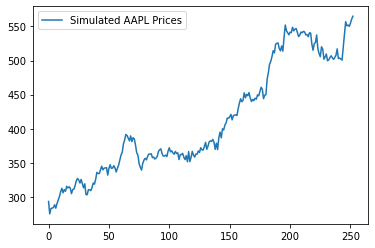

In [19]:
# Use the `plot` function to plot the trajectory of AAPL stock based on a 252 trading day simulation
simulated_price_df.plot()

### Calculate Daily Returns of Simulated Stock Prices for AAPL

In [20]:
# Use the `pct_change` function to calculate daily returns of simulated stock prices for AAPL
simulated_daily_returns = simulated_price_df.pct_change()
simulated_daily_returns.head()

,Simulated AAPL Prices
0,NaN
1,-0.062273
2,0.028985
3,0.001845
4,0.002527


### Calculate the Cumulative Returns of Simulated Stock Prices for AAPL

In [21]:
# Use the `cumprod` function to calculate the cumulative returns of simulated stock prices for AAPL
simulated_cumulative_returns = (1 + simulated_daily_returns).cumprod()
simulated_cumulative_returns.head()

,Simulated AAPL Prices
0,NaN
1,0.937727
2,0.964906
3,0.966687
4,0.969129


### Calculate the Cumulative Profits/Losses of Simulated Stock Prices for AAPL

In [22]:
# Multiply an initial investment by the cumulative returns of simulative stock prices to
# return the progression of cumulative returns in terms of money
initial_investment = 10000
cumulative_pnl = initial_investment * simulated_cumulative_returns
cumulative_pnl.head()

,Simulated AAPL Prices
0,NaN
1,9377.265357
2,9649.060905
3,9666.866436
4,9691.293140


### Plot the Cumulative Profits/Losses of `$10,000` in AAPL Over the Next `252` Trading Days

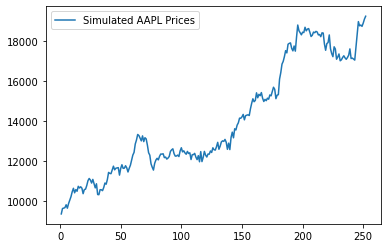

In [23]:
# Use the "plot" function to create a chart of the cumulative profits/losses
cumulative_pnl.plot()